<a href="https://colab.research.google.com/github/seki-shu/Group15_Multimodal/blob/Robosuite/Dreamer_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Import libraries

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torch.distributions as td
from torch.distributions import Normal, Categorical, OneHotCategorical, OneHotCategoricalStraightThrough, Bernoulli
from torch.distributions.kl import kl_divergence
from torch.utils.tensorboard import SummaryWriter
from torch.nn.utils import clip_grad_norm_

import numpy as np

import os
import time
import random

from PIL import Image

torch.cuda.empty_cache()

## Check device

In [ ]:
# torch.deviceを定義．この変数は後々モデルやデータをGPUに転送する時にも使います
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## TrainedModels

In [ ]:
class TrainedModels:
    def __init__(self, *models):
        """
        コンストラクタ.
        使用例: trained_models = TrainedModels(encoder, rssm, critic, actor)

        Params:
        -------
            models : nn.Module
                保存するモデル. 複数選択可.
        """
        assert np.all([nn.Module in model.__class__.__bases__ for model in models]), "models must be nn.Module"
        self.models = models

    def save(self, dir: str):
        """
        モデルを保存するメソッド.
        コンストラクタで渡したモデルをすべて保存する.

        Params:
        -------
            dir : str
                保存先ディレクトリ.
        """
        for model in self.models:
            torch.save(
                model.state_dict(),
                os.path.join(dir, f"{model.__class__.__name__}.pt")
            )

    def load(self, dir: str, device: str):
        """
        モデルを読み込むメソッド.
        ※モデルの名前とファイルの名前は同じにする.

        Params:
        -------
            dir : str
                読み込むディレクトリ.
            device : str
                読み込むデバイス. 'cpu', 'cuda'
        """
        for model in self.models:
            model.load_state_dict(
                torch.load(
                    os.path.join(dir, f"{model.__class__.__name__}.pt"),
                    map_location=device
                )
            )

## set_seed

In [ ]:
def set_seed(seed: int):
    """
    Pytorchとnumpyのseed値を固定する.

    Params:
    -------
        seed : int
          シード値.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# モデルの実装


## RSSM

In [ ]:
class RSSM(nn.Module):
    """
    RSSMのクラス.

    Methods:
    --------
        recurrent: 決定的状態hをrnnで得る.
        get_prior: 確率的状態zの事前分布を得る.
        get_posterior: 確率的状態zの事後分布を得る.
    """
    def __init__(self, mlp_hidden_dim: int, h_dim: int, z_dim: int, a_dim: int, n_classes: int, embedding_dim: int):
        """
        コンストラクタ.

        Params:
        --------
            mlp_hidden_dim : int
               mlpに通した後の次元数.
            h_dim : int
               決定的状態hの次元数.
            z_dim : int
               確率的状態zの次元数.
            a_dim : int
               行動の次元数.
            n_classes : int
               確率的状態zのカテゴリ数.
            embedding_dim : int
               観測画像の埋め込み次元数.
        """
        super().__init__()

        self.h_dim = h_dim
        self.z_dim = z_dim
        self.a_dim = a_dim
        self.n_classes = n_classes

        # Recurrent model
        # h_t = f(h_t-1, z_t-1, a_t-1)
        self.z_a_hidden = nn.Linear(z_dim * n_classes + a_dim, mlp_hidden_dim)
        self.rnn = nn.GRUCell(mlp_hidden_dim, h_dim)

        # Prior prediction
        # z_t+1_hat = f(h_t+1)
        self.prior_hidden = nn.Linear(h_dim, mlp_hidden_dim)
        self.prior_logits = nn.Linear(mlp_hidden_dim, z_dim * n_classes)

        # Posterior
        # z_t+1 = f(h_t+1, o_t+1)
        self.posterior_hidden = nn.Linear(h_dim + embedding_dim, mlp_hidden_dim)
        self.posterior_logits = nn.Linear(mlp_hidden_dim, z_dim * n_classes)

    def recurrent(self, h_prev: torch.Tensor, z_prev: torch.Tensor, a_prev: torch.Tensor):
        """
        決定的状態の状態遷移を求めるメソッド. RNNとしてGRUを使用する.
        h_t+1 = f(h_t, z_t, a_t)

        Params:
        -------
            h_prev : torch.Tensor (batch size, h_dim)
                現在時刻の決定的状態h_t
            z_prev : torch.Tensor (batch size, z_dim)
                現在時刻の確率的状態z_t
            a_prev : torch.Tensor (batch size, a_dim)
                現在時刻のアクションa_t

        Returns:
        -------
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1
        """
        mlp_hidden = F.elu(self.z_a_hidden(torch.cat([z_prev, a_prev], dim=1)))
        # h = self.rnn(mlp_hidden, mlp_hidden)
        h = self.rnn(mlp_hidden, h_prev)
        return h

    def get_prior(self,h: torch.Tensor, detach = False):
        """
        確率的状態zの事前分布を求めるメソッド.
        z_t+1_hat ~ p(h_t+1)

        Params:
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1.
            detach : bool
                Trueの場合、detachする.

        ---------
        Returns:
            prior : torch.distributions.Distribution
                事前分布を求めるためのカテゴリカル分布.
            detached_prior : torch.distributions.Independent
                detachされた事前分布を求めるためのカテゴリカル分布.
        """
        mlp_hidden = F.elu(self.prior_hidden(h))
        logits = self.prior_logits(mlp_hidden) # (B, z_dim * n_classes,)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.n_classes) # (B, z_dim, n_classes)

        prior = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detached_logits = logits.detach().clone()  # Detach and clone to avoid in-place modification
            detached_prior = td.Independent(OneHotCategoricalStraightThrough(logits=detached_logits), 1)
            return prior, detached_prior
        return prior

    def get_posterior(self, h: torch.Tensor, embedded_obs: torch.Tensor, detach = False):
        """
        確率的状態zの事後分布を求めるメソッド.
        z_t+1 ~ p(h_t+1, o_t+1)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                次時刻の決定的状態h_t+1.
            embedded_obs : torch.Tensor (batch size, embedding_dim)
                次時刻の画像の埋め込み
            detach : bool
                Trueの場合、detachする.

        Returns:
        --------
            posterior : torch.distributions.Distribution
                事後分布を求めるためのカテゴリカル分布.
            detached_posterior : torch.distributions.Independent
                detachされた事後分布を求めるためのカテゴリカル分布.
        """
        mlp_hidden = F.elu(self.posterior_hidden(torch.cat([h, embedded_obs], dim=1)))
        logits = self.posterior_logits(mlp_hidden) # (B, z_dim * n_classes)
        logits = logits.reshape(logits.shape[0], self.z_dim, self.n_classes) # (B, z_dim, n_classes)

        posterior = td.Independent(OneHotCategoricalStraightThrough(logits=logits), 1)
        if detach:
            detached_logits = logits.detach().clone()  # Detach and clone to avoid in-place modification
            detached_posterior = td.Independent(OneHotCategoricalStraightThrough(logits=detached_logits), 1)
            return posterior, detached_posterior
        return posterior

## Encoder

In [ ]:
class Encoder(nn.Module):
    """
    ※画像(1, 64, 64)をエンコードする.
    画像はカラーじゃなくてグレースケールにするのでチャネル数が1.

    Methods:
    -------
        forward: 観測画像を埋め込む.
    """
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 48, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(48, 96, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(96, 192, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(192, 384, kernel_size=4, stride=2)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        """
        順伝播を行うメソッド．観測画像をベクトルに埋め込む．
        (1, 64, 64) -> (1536, ) にエンコード.

        Params:
        -------
            obs : torch.Tensor (batch size, 1, 64, 64)
                環境から得られた観測画像．

        Returns:
        -------
            embed : torch.Tensor (batch size, 1536)
                観測を1024次元のベクトルに埋め込んだもの．
        """
        embed = F.elu(self.conv1(obs))
        embed = F.elu(self.conv2(embed))
        embed = F.elu(self.conv3(embed))
        embed = self.conv4(embed).reshape(embed.shape[0], -1)
        return embed

## Decoder

In [ ]:
class Decoder(nn.Module):
    """
    内部状態表現h, zから画像(1, 256, 256)を再構成する.
    ただし画像は平均を計算して、その平均で分散１の正規分布から得る.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int):
        """
        コンストラクタ．

        Params:
        --------
            h_dim : int
                決定的状態hの次元数．
            z_dim : int
                確率的状態zの次元数．
            n_classes : int
                確率的状態zのカテゴリ数．
        """
        super().__init__()
        # fcの出力を適切に調整 (128 * 4 * 4 に変更)
        self.fc = nn.Linear(h_dim + z_dim * n_classes, 128 * 4 * 4)
        # デコンボリューション層を調整
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)  # (4x4 -> 8x8)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)   # (8x8 -> 16x16)
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)   # (16x16 -> 32x32)
        self.deconv4 = nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1)    # (32x32 -> 64x64)
        self.deconv5 = nn.ConvTranspose2d(8, 1, kernel_size=4, stride=4, padding=0)     # (64x64 -> 256x256)

    def forward(self, h: torch.Tensor, z: torch.Tensor):
        """
        順伝播を行うメソッド．内部状態h, zから画像を再構成する．
        mean = f(h_t, z_t)
        o_t = N(mean, 1)

        Params:
        --------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            obs_dist : torch.distributions.Independent
                再構成された画像を得るための多変量正規分布．
        """
        # fcで次元を調整
        x = self.fc(torch.cat([h, z], dim=1))
        x = x.view(x.size(0), 128, 4, 4)  # チャンネル数: 128, 解像度: 4x4

        # デコンボリューションを通じて画像を生成
        x = F.elu(self.deconv1(x))
        x = F.elu(self.deconv2(x))
        x = F.elu(self.deconv3(x))
        x = F.elu(self.deconv4(x))
        mean = self.deconv5(x)  # 最終出力: 256x256

        # 再構成された分布を生成
        obs_dist = td.Independent(Normal(mean, 1), 3)
        return obs_dist
# class Decoder(nn.Module):
#     """
#     内部状態表現h, zから画像(1, 256, 256)を再構成する.
#     ただし画像は平均を計算して、その平均で分散１の正規分布から得る.

#     Methods:
#         forward: 画像の再構成を行う.
#     """
#     def __init__(self, h_dim: int, z_dim: int, n_classes: int):
#         """
#         コンストラクタ．

#         Params:
#         --------
#             h_dim : int
#                 決定的状態hの次元数．
#             z_dim : int
#                 確率的状態zの次元数．
#             n_classes : int
#                 確率的状態zのカテゴリ数．
#         """
#         super().__init__()
#         self.fc = nn.Linear(h_dim + z_dim * n_classes, 75264)
#         self.deconv1 = nn.ConvTranspose2d(75264, 192, kernel_size=5, stride=2)
#         self.deconv2 = nn.ConvTranspose2d(192, 96, kernel_size=5, stride=2)
#         self.deconv3 = nn.ConvTranspose2d(96, 48, kernel_size=6, stride=2)
#         self.deconv4 = nn.ConvTranspose2d(48, 1, kernel_size=6, stride=2)

#     def forward(self, h: torch.Tensor, z: torch.Tensor):
#         """
#         順伝播を行うメソッド．内部状態h, zから画像を再構成する．
#         mean = f(h_t, z_t)
#         o_t = N(mean, 1)

#         Params:
#         --------
#             h : torch.Tensor (batch size, h_dim)
#                 決定的状態h
#             z : torch.Tensor (batch size, z_dim * n_classes)
#                 確率的状態z

#         Returns:
#         -------
#             obs_dist : torch.distributions.Independent
#                 再構成された画像を得るための多変量正規分布．
#         """
#         x = self.fc(torch.cat([h, z], dim=1))
#         x = x.reshape(x.shape[0], 75264, 1, 1)
#         x = F.elu(self.deconv1(x))
#         x = F.elu(self.deconv2(x))
#         x = F.elu(self.deconv3(x))
#         mean = self.deconv4(x)
#         obs_dist = td.Independent(Normal(mean, 1), 3)
#         return obs_dist


## Reward Model

In [ ]:
class RewardModel(nn.Module):
    """
    報酬予測モデル.
    ただし報酬は平均を計算して、その平均で分散が1の正規分布から得る.

    Methods:
    -------
        forward: 報酬予測を行う.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.

        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        報酬予測を行うメソッド.
        mean = f(h_t, z_t)
        r_t = N(mean, 1)

        Params:
        ----------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            reward_dist : torch.distributions.Independent
                報酬予測をするための多変量正規分布.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        mean = self.fc4(x)
        reward_dist = td.Independent(Normal(mean, 1), 1)
        return reward_dist

## Discount Model


In [ ]:
class DiscountModel(nn.Module):
    """
    現在のエピソードが終端かどうかを求めるモデル.

    Methods:
    --------
        forward: 終端かどうか予測を行う.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        現在のエピソードが終端かどうか求める.
        p = f(h_t, z_t)
        gamma_t = Bernoulli(p)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z

        Returns:
        -------
            discount_dist : torch.distributions.Independent
                終端かどうか予測を行うベルヌーイ分布
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        p_logits = self.fc4(x)
        discount_dist = td.Independent(Bernoulli(logits=p_logits), 1)
        return discount_dist

## Actor

In [ ]:
class Actor(nn.Module):
    """
    最適行動を出力するモデル.
    今回はAtariではないので連続な行動を出力する.

    Methods:
    -------
        forward: 最適行動を出力する.
    """
    def __init__(self, action_dim: int, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            action_dim : int
                行動の次元数.
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, action_dim)
        self.fc_std = nn.Linear(hidden_dim, action_dim)

    def forward(self, h: torch.Tensor, z: torch.Tensor, eval: bool):
        """
        最適行動を出力する.
        a_t = f(h_t, z_t)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h.
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z.
            eval : bool
                評価モードかどうか.

        Returns:
        -------
            actions : torch.Tensor (batch size, action_dim)
                最適行動.
            action_log_probs : torch.Tensor (batch size, 1)
                最適行動の対数尤度.
            action_entropy : torch.Tensor (batch size, 1)
                最適行動のエントロピー.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        mean = self.fc_mean(x) # (batch_size, action_dim)
        std = F.softplus(self.fc_std(x))

        if eval:
            actions = torch.tanh(mean) # action spaceを(-1, 1)にしてる. 環境によっては変更必要かも.
            return actions, None, None

        # Dreamer V2の連続空間でのActorがどうなっているかいまいち分からなかったので、とりあえず以下のように実装しました。
        # まずactionを正規分布からサンプルした後、tanh関数に通して(-1, 1)にします。
        # 対数尤度を求めるときに、log p(actions) = log Normal(unscaled_actions) * |det(∂unscaled_actions / ∂actions)|(https://arxiv.org/pdf/1801.01290 Appendix C)となります
        # tanhの微分は1-tanh^2で、正規分布の分散共分散行列は対角行列なので、ヤコビアンはdiag(1 - tanh^2)となります。
        # 間違ってるかもしれません...
        action_dist = td.Independent(Normal(mean, std), 1)
        unscaled_actions = action_dist.rsample()
        actions = torch.tanh(unscaled_actions)

        action_log_probs = action_dist.log_prob(unscaled_actions).sum(dim=-1, keepdim=True)
        # action_log_probs = action_dist.log_prob(unscaled_actions) - torch.log(1 - actions.pow(2) + 1e-7).sum(dim=1, keepdim=True)
        action_entropy = action_dist.entropy()
        return actions, action_log_probs, action_entropy

## Critic

In [ ]:
class Critic(nn.Module):
    """
    状態価値を出力するモデル.

    Methods:
    --------
        forward: 状態価値を出力する.
    """
    def __init__(self, h_dim: int, z_dim: int, n_classes: int, hidden_dim: int):
        """
        コンストラクタ.

        params:
        -------
            h_dim : int
                決定的状態hの次元数.
            z_dim : int
                確率的状態zの次元数.
            n_classes : int
                確率的状態zのカテゴリ数.
            hidden_dim : int
                MLPを通した後のユニット数.
        """
        super().__init__()
        self.fc1 = nn.Linear(h_dim + z_dim * n_classes, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, 1)

    def forward(self, h: torch.Tensor, z: torch.Tensor):
        """
        状態価値を出力する.
        v_t = f(h_t, z_t)

        Params:
        -------
            h : torch.Tensor (batch size, h_dim)
                決定的状態h.
            z : torch.Tensor (batch size, z_dim * n_classes)
                確率的状態z.

        Return:
        -------
            values : torch.Tensor (batch size, 1)
                状態価値.
        """
        x = F.elu(self.fc1(torch.cat([h, z], dim=1)))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        values = self.out(x)
        return values

# その他機能

## Replay Buffer


In [ ]:
class ReplayBuffer:
    """
    リプレイバッファ.
    """
    def __init__(self, capacity: int, obs_shape: tuple[int], action_dim: int):
        """
        コンストラクタ.

        Params:
        -------
            capacity : int
                バッファの最大容量.
            obs_shape : tuple[int]
                観測の形状.
            action_dim : int
                行動の次元数.
        """
        self.capacity = capacity
        self.obs_shape = obs_shape
        self.action_dim = action_dim

        self.observations = np.zeros((capacity, *obs_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, action_dim), dtype=np.float32)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.dones = np.zeros((capacity, 1), dtype=bool)
        self.index = 0
        self.is_filled = False

    def push(self, observation: np.ndarray, action: np.ndarray, reward: float, done: bool):
        """
        バッファに追加する.

        Params:
        -------
            observation : np.ndarray (obs_shape)
                観測.
            action : np.ndarray (action_dim)
                行動.
            reward : float
                報酬.
            done : bool
                エピソードの終了.
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.dones[self.index] = done

        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size: int, chunk_length: int) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        バッファからサンプリングする.

        Params:
        -------
            batch_size : int
                サンプリングするデータの数.

            chunk_length : int
                chunkの長さ

        Returns:
        --------
            sampled_observations : np.ndarray (B, T, 1, 64, 64)
                サンプリングされた観測.
            sampled_actions : np.ndarray (B, T, action_dim)
                サンプリングされた行動.
            sampled_rewards : np.ndarray (B, T, 1)
                サンプリングされた報酬.
            sampled_dones : np.ndarray (B, T, 1)
                サンプリングされたエピソードの終了判定.
        """
        episode_borders = np.where(self.dones)[0] # episodeが終了するindex
        sampled_indices = []
        for _ in range(batch_size):
            crossed_border = True # borderを跨いだかどうか
            while crossed_border:
                initial_idx = np.random.randint(self.capacity - chunk_length + 1)
                final_idx = initial_idx + chunk_length - 1
                crossed_border = np.logical_and(initial_idx <= episode_borders,
                                                episode_borders < final_idx).any()
            sampled_indices += list(range(initial_idx, final_idx + 1)) # 最終的に(batch_size * chunk_length)

        sampled_observations = self.observations[sampled_indices].reshape(
            batch_size, chunk_length, *self.obs_shape)
        sampled_actions = self.actions[sampled_indices].reshape(
            batch_size, chunk_length, self.action_dim)
        sampled_rewards = self.rewards[sampled_indices].reshape(
            batch_size, chunk_length, 1)
        sampled_dones = self.dones[sampled_indices].reshape(
            batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_dones

    def save(self, dir: str):
        np.save(f"{dir}/observations.npy", self.observations)
        np.save(f"{dir}/actions.npy", self.actions)
        np.save(f"{dir}/rewards.npy", self.rewards)
        np.save(f"{dir}/dones.npy", self.dones)

    def load(self, dir: str):
        self.observations = np.load(f"{dir}/observations.npy")
        self.actions = np.load(f"{dir}/actions.npy")
        self.rewards = np.load(f"{dir}/rewards.npy")
        self.dones = np.load(f"{dir}/dones.npy")


## calculate λ-target  
元論文ではλ: 0.95, H=15  
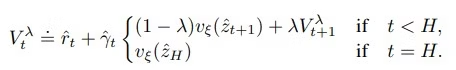

In [ ]:
def calculate_lambda_target(rewards: torch.Tensor, discounts: torch.Tensor, values: torch.Tensor, lambda_: float):
    """
    λ-targetを計算する.

    Params:
    -------
        rewards : torch.Tensor (imagination_horizon, D)
            報酬. 1次元目が時刻tを表しており、2次元目は自由な変数で、想像の軌道を作成するとき入力されるindex.
        discounts : torch.Tensor (imagination_horizon, D)
            割引率.
        values : torch.Tensor (imagination_horizon, D)
            状態価値.
        lambda_ : float
            λ. 元論文ではλ=0.95

    Returns:
    -------
        V_lambda : torch.Tensor (imagination_horizon, D)
            lambda_targetの値.
    """
    V_lambda = torch.zeros_like(rewards)

    for t in reversed(range(rewards.shape[0])):
        if t == rewards.shape[0] - 1: # t = H(下の条件式)
            V_lambda[t] = rewards[t] + discounts[t] * values[t]
        else:
            V_lambda[t] = rewards[t] + discounts[t] * ((1 - lambda_) * values[t+1] + lambda_ * V_lambda[t+1])

    return V_lambda

## Preprocess obs

In [ ]:
def preprocess_obs(obs):
    """
    画像の変換. [0, 255] -> [0, 1]
    画像をグレースケールに変換
    """
    height, width = 256, 256
    transform = T.Compose([
        T.Grayscale(num_output_channels=1),  # グレースケール変換
        T.Resize((height, width)),     # リサイズ
        T.ToTensor()                   # PIL Image を Tensor に変換
    ])
    obs = obs["agentview_image"]
    obs = Image.fromarray(obs)
    # リサイズとグレースケール変換を適用
    obs = transform(obs)  # (1, height, width)
    # obs = obs.convert("L") # grayscaleにしてる
    obs = np.array(obs).reshape(height, width, 1)
    obs = obs.astype(np.float32) / 255.0 - 0.5
    return obs

# 学習

## Agent

In [ ]:
class Agent:
    """
    Agentのクラス.

    Methods:
    --------
        __call__: Agentが一連の流れを行う.
        reset: 決定的状態hのリセット.
    """
    def __init__(self, encoder, rssm, actor):
        self.encoder = encoder
        self.rssm = rssm
        self.actor = actor
        self.device = next(self.actor.parameters()).device
        self.h = torch.zeros(1, rssm.h_dim, device=self.device)

    def __call__(self, obs, eval=False):
        """
        preprocessを適用＋Channel-Firstに変換.
        その後画像をエンコードして事後分布を取得.
        事後分布とhから行動を選択.
        最後に事後分布と行動を基にhを更新.

        Params:
        -------
            obs : np.ndarray (64, 64, 3)だと思う.
                環境から得られた観測画像.(preprocess前).
            eval : bool
                訓練か評価時か

        Returns:
        --------
            action : np.ndarray (action_dim, )のはず.
                観測画像に対する行動の予測.
        """
        obs = preprocess_obs(obs)
        obs = torch.as_tensor(obs, device=self.device)
        # obs.transpose(1, 2).transpose(0, 1).unsqueeze(0) # channel-firstに (1, C, H, W)
        # チャネル次元を最初に移動 (H, W, C) -> (C, H, W)
        obs = obs.permute(2, 0, 1)
        # バッチ次元を追加 (C, H, W) -> (1, C, H, W)
        obs = obs.unsqueeze(0)

        with torch.no_grad():
            # 観測を低次元に変換し、得られたposteriorをActorに入れて行動を決定する.
            embedded_obs = self.encoder(obs)
            z_posterior_dist = self.rssm.get_posterior(self.h, embedded_obs)
            z_posterior = z_posterior_dist.sample().flatten(1) # (1, z_dim, n_classes)を(1, z_dim * n_classes)にflatten
            action, _, _ = self.actor(self.h, z_posterior, eval=eval) # 行動の取得 (1, action_dim)
            self.h = self.rssm.recurrent(self.h, z_posterior, action) # hの更新

        return action.squeeze().cpu().numpy() # (action_dim, )

    def reset(self):
        """
        隠れ状態のreset.
        """
        self.h = torch.zeros(1, self.rssm.h_dim, device=self.device)


## Config

In [ ]:
class Config:
    def __init__(self, **kwargs):
        # data settings
        self.buffer_size = 100_000
        self.batch_size = 16
        self.seq_length = 16
        self.imagination_horizon = 15

        # model dimensions
        self.z_dim = 32
        self.n_classes = 32
        self.h_dim = 600
        self.mlp_hidden_dim = 400
        self.embedding_dim = 75264

        # learning parameters
        self.model_lr = 2e-4 # world model(transition / prior / posterior / discount / image predictor)の学習率
        self.actor_lr = 4e-5
        self.critic_lr = 1e-4
        self.epsilon = 1e-5 # optimizerのεの値
        self.weight_decay = 1e-6
        self.gradient_clipping = 100
        self.kl_loss_scale = 0.1
        self.kl_balance = 0.8
        self.actor_entropy_scale = 1e-4 # 連続値制御の場合 Atariの場合は1e-3
        self.slow_critic_update = 100
        self.reward_loss_scale = 1.0
        self.discount_loss_scale = 1.0
        self.update_freq = 4

        # lambda return params
        self.discount = 0.995 # 割引率
        self.lambda_ = 0.95

        # learning period settings
        self.seed_iter = 10000 # 事前にランダム行動で探索する回数
        self.eval_freq = 1e3
        self.eval_episodes = 5

cfg = Config()

## モデル等の初期化

In [ ]:
%pip install robosuite
%pip install moviepy

import robosuite as suite
import time
import pandas as pd
import matplotlib.pyplot as plt
import moviepy.editor as mpy
from base64 import b64encode
from IPython.display import HTML
from google.colab import files
import uuid, shutil
from typing import List
import numpy as np
from moviepy.editor import ImageSequenceClip
from IPython.display import display, clear_output

import os

## シミュレーション環境の初期化

In [ ]:
# 環境の初期化
env = suite.make(
    env_name="Lift",  # タスク名
    robots="Panda",  # 使用するロボット
    has_renderer=False,  # 動画出力のためレンダラーをオフ
    has_offscreen_renderer=True,  # オフスクリーンレンダリングを有効化
    render_camera="agentview",  # カメラの視点
    use_camera_obs=True,  # カメラの観測を有効化
    control_freq=20,  # 制御周波数
)
# 環境の初期化
eval_env = suite.make(
    env_name="Lift",  # タスク名
    robots="Panda",  # 使用するロボット
    has_renderer=False,  # 動画出力のためレンダラーをオフ
    has_offscreen_renderer=True,  # オフスクリーンレンダリングを有効化
    render_camera="agentview",  # カメラの視点
    use_camera_obs=True,  # カメラの観測を有効化
    control_freq=20,  # 制御周波数
)

# 動画保存用のフレームリスト
frames = []
# 環境のリセット
obs = env.reset()


[robosuite INFO] Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:69)
INFO:robosuite_logs:Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json
[robosuite INFO] Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:69)
INFO:robosuite_logs:Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json
[robosuite INFO] Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/robots/default_panda.json (composite_controller_factory.py:69)
INFO:robosuite_logs:Loading controller configuration from: /usr/local/lib/python3.10/dist-packages/robosuite/controllers/config/

In [ ]:
# アクションスペックを取得
low, high = env.action_spec

# 行動次元を確認
action_dim = low.shape[0]

# 行動の範囲を表示
print("行動次元:", action_dim)
print("最小値:", low)
print("最大値:", high)


行動次元: 7
最小値: [-1. -1. -1. -1. -1. -1. -1.]
最大値: [1. 1. 1. 1. 1. 1. 1.]


## モデルの初期化

In [ ]:
seed = 0
set_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#replay buffer
replay_buffer = ReplayBuffer(
    capacity = cfg.buffer_size,
    obs_shape = (256, 256, 1),
    # obs_shape = (64, 64, 1),
    action_dim = action_dim
)

#models
rssm = RSSM(cfg.mlp_hidden_dim, cfg.h_dim, cfg.z_dim, action_dim, cfg.n_classes, cfg.embedding_dim).to(device)
encoder = Encoder().to(device)
decoder = Decoder(cfg.h_dim, cfg.z_dim, cfg.n_classes).to(device)
reward_model = RewardModel(cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
discount_model = DiscountModel(cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
actor = Actor(action_dim, cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
critic = Critic(cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
target_critic = Critic(cfg.h_dim, cfg.z_dim, cfg.n_classes, cfg.mlp_hidden_dim).to(device)
target_critic.load_state_dict(critic.state_dict())

trained_models = TrainedModels(
    rssm,
    encoder,
    decoder,
    reward_model,
    discount_model,
    actor,
    critic
)

# optimizer
wm_parameters = list(rssm.parameters())          + \
            list(encoder.parameters())       + \
            list(decoder.parameters())       + \
            list(reward_model.parameters())  + \
            list(discount_model.parameters())
wm_optimizer = torch.optim.AdamW(wm_parameters, lr=cfg.model_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
actor_optimizer = torch.optim.AdamW(actor.parameters(), lr=cfg.actor_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
critic_optimizer = torch.optim.AdamW(critic.parameters(), lr=cfg.critic_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)

## evaluation

In [ ]:
def evaluation(eval_env: eval_env, agent: Agent, step: int, cfg: Config):
    """
    評価用の関数.

    Params:
    -------
        eval_env : RepeatAction
            評価用の環境.
        agent : Agent
            Agentのインスタンス.
        step : int
            現在のステップ数.
        cfg : Config
            Config.

    Returns:
    --------
        max_ep_rewards : float
            評価中に1エピソードで得た最大の報酬和.
    """
    env = eval_env
    all_ep_rewards = []

    with torch.no_grad():
        for i in range(cfg.eval_episodes):
            obs = env.reset() # 環境をリセット
            agent.reset() # 隠れ状態をリセット
            done = False
            episode_reward = 0 # エピソードでの報酬和
            while not done:
                action = agent(obs, eval=True) # (action_dim, )
                obs, reward, done, _ = env.step(action) # 環境を進める
                episode_reward += reward
            all_ep_rewards.append(episode_reward)

        mean_ep_rewards = np.mean(all_ep_rewards)
        max_ep_rewards = np.max(all_ep_rewards)
        print(f"Eval(iter={step}) mean: {mean_ep_rewards:.4f} max: {max_ep_rewards:.4f}")

    return max_ep_rewards, mean_ep_rewards

## ランダム行動でバッファを埋める

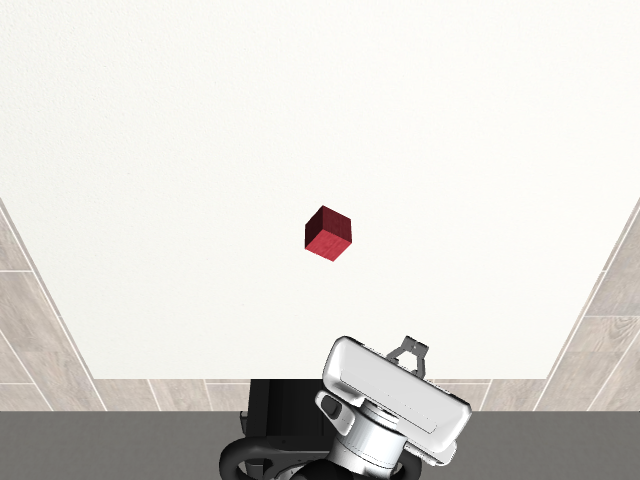

Moviepy - Building video lift_task_learning.mp4.
Moviepy - Writing video lift_task_learning.mp4



Moviepy - Done !
Moviepy - video ready lift_task_learning.mp4


In [ ]:
obs = env.reset()
done = False
Tx = 0
for _ in range(cfg.seed_iter):
    # ランダムなアクションを生成
    action = np.random.uniform(low, high)
    next_obs, reward, done, _ = env.step(action)
    replay_buffer.push(preprocess_obs(obs), action, reward, done) # Atari環境じゃないのでrewardをtanhで[-1, 1]にしない.

    # # 現在のフレームを取得
    # frame = env.sim.render(
    #     width=640, height=480, camera_name="agentview"
    # )  # フレームを取得

    # # PIL イメージに変換して表示
    # image = Image.fromarray(frame)
    # clear_output(wait=True)  # 前回のフレームをクリア
    # display(image)  # 新しいフレームを表示

    # time.sleep(0.05)  # 適切な間隔を設定（制御周波数に応じて）
    # frames.append(frame)

    if done:
        obs = env.reset()
        done = False

    else:
        obs = next_obs
# # 動画として保存
# clip = ImageSequenceClip(frames, fps=20)
# clip.write_videofile("lift_task_learning.mp4", codec="libx264")

## 実際に学習を行う

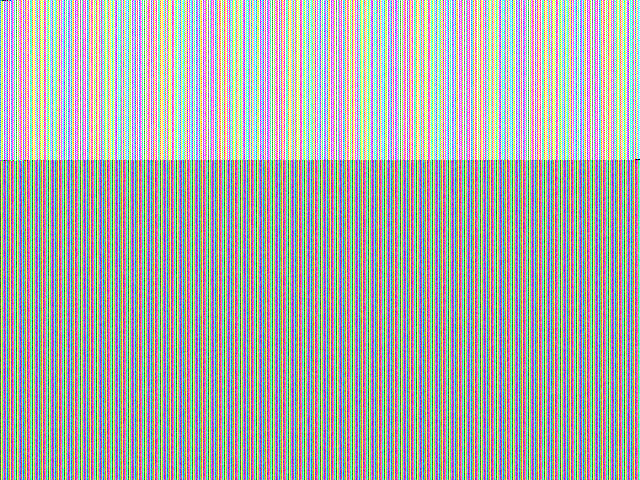

In [ ]:
# torch.autograd.set_detect_anomaly(False)
torch.autograd.set_detect_anomaly(True)

agent = Agent(encoder, rssm, actor)
# 学習曲線の表示
log_dir = 'logs'
writer = SummaryWriter(log_dir)
# tensorboard --logdir='./logs'

# 環境・収益の初期化
obs = env.reset()
done = False
total_reward = 0
total_episode = 1
best_reward = -1
NUM_ITER = 5000

start = time.time()
Tx = 0
for iteration in range(NUM_ITER - cfg.seed_iter):
    # ReplayBufferにデータを追加する.
    with torch.no_grad():
        # 環境と相互作用
        action = agent(obs) # (action_dim, )
        next_obs, reward, done, _ = env.step(action)
        # # 現在のフレームを取得
        # frame = env.sim.render(
        #     width=640, height=480, camera_name="agentview"
        # )  # フレームを取得

        # # PIL イメージに変換して表示
        # image = Image.fromarray(frame)
        # clear_output(wait=True)  # 前回のフレームをクリア
        # display(image)  # 新しいフレームを表示

        # time.sleep(0.05)  # 適切な間隔を設定（制御周波数に応じて）
        # frames.append(frame)
        # 得たデータをReplayBufferに追加して更新
        replay_buffer.push(preprocess_obs(obs), action, reward, done)
        obs = next_obs
        total_reward += reward

    #モデルの学習
    if (iteration + 1) % cfg.update_freq == 0:
        # ReplayBufferからdataをsamplingする.
        # (batch_size, seq_length, *data_shape)
        observations, actions, rewards, dones =\
            replay_buffer.sample(cfg.batch_size, cfg.seq_length)
        dones = 1 - dones # 終了して無いときは割引率は1にして、終了時割引率0にするので逆にする.
        # torchで扱える形に変形
        # 各時刻tごとに処理をしたいので、seq lengthを先頭に持ってくる.
        observations = torch.permute(torch.as_tensor(observations, device=device), (1, 0, 4, 2, 3)) # (T, B, C, H, W)
        actions = torch.as_tensor(actions, device=device).transpose(0, 1) # (T, B, action_dim)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1) # (T, B, 1)
        dones = torch.as_tensor(dones, device=device).transpose(0, 1) # (T, B, 1)

        # =================
        # world modelの学習
        #   画像をすべてEncodeした後,z_t, h_t, z, hを初期化.
        #   その後時刻tごとにh, zを埋めて、損失を全体で損失を計算する.
        # =================
        # すべての観測をベクトルに埋め込み
        emb_observations = encoder(observations.reshape(-1, 1, 256, 256)).view(cfg.seq_length, cfg.batch_size, -1) # (T, B, 1536)
        # 状態表現z，行動aはゼロで初期化
        # バッファから取り出したデータをt={1, ..., seq length}とするなら，以下はz_1とみなせる
        z0 = torch.zeros(cfg.batch_size, cfg.z_dim * cfg.n_classes, device=device)
        h0 = torch.zeros(cfg.batch_size, cfg.h_dim, device=device)
        # 各時刻tごとのz,hを保存するためのtensorを定義
        z = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.z_dim * cfg.n_classes, device=device)
        h = torch.zeros(cfg.seq_length, cfg.batch_size, cfg.h_dim, device=device)
        # KL lossの計算
        kl_loss = 0
        for t in range(cfg.seq_length-1):
            # hの更新
            # h[t+1] = rssm.recurrent(h[t], z[t], actions[t]) # h_t+1
            h0 = rssm.recurrent(h0, z[t], actions[t]) # h_t+1
            # prior, posteriorのdistribution
            prior, detached_prior = rssm.get_prior(h0, detach=True)
            posterior, detached_posterior = rssm.get_posterior(h0, emb_observations[t+1], detach=True)
            # posteriorからsampling
            z0 = posterior.rsample().flatten(1) # (B, z_dim * n_classes)
            h[t+1] = h0
            z[t+1] = z0
            # KL lossの計算 KL-balancing使ってる
            kl_loss = kl_loss +  cfg.kl_balance * torch.mean(kl_divergence(detached_posterior, prior)) + \
             (1 - cfg.kl_balance) * torch.mean(kl_divergence(posterior, detached_prior))
        kl_loss = kl_loss / (cfg.seq_length - 1)

        # 初期状態は使わない
        h = h[1:] # (seq_length - 1, batch_size, h_dim)
        z = z[1:] # (seq_length - 1, batch_size, z_dim * n_classes)
        # 得られた状態から再構成・報酬・終端フラグを予測
        # そのままでは時間方向、バッチ方向で次元が多いため平坦化
        h_flat = h.view(-1, cfg.h_dim) # ((T-1) * B, h_dim)
        z_flat = z.view(-1, cfg.z_dim * cfg.n_classes) # ((T-1) * B, z_dim * n_classes)

        #再構成、報酬、終端フラグ予測
        recon_obs_dist = decoder(h_flat, z_flat) # ((T-1) * B, C, H, W)
        reward_dist = reward_model(h_flat, z_flat) # ((T-1) * B, 1)
        discount_dist = discount_model(h_flat, z_flat) # ((T-1) * B, 1)

        # 各予測に対する対数尤度（損失関数なのでマイナスつける）
        C, H, W = observations.shape[2:]
        obs_loss = -torch.mean(recon_obs_dist.log_prob(observations[1:].reshape(-1, C, H, W)))
        reward_loss = -torch.mean(reward_dist.log_prob(rewards[:-1].reshape(-1, 1)))
        discount_loss = -torch.mean(discount_dist.log_prob(dones[:-1].float().reshape(-1, 1)))

        # 損失の総和を取る
        wm_loss = obs_loss + cfg.reward_loss_scale * reward_loss + cfg.discount_loss_scale * discount_loss + cfg.kl_loss_scale * kl_loss
        # 更新
        wm_optimizer.zero_grad()
        wm_loss.backward()
        clip_grad_norm_(wm_parameters, cfg.gradient_clipping)
        wm_optimizer.step()

        # ====================
        # Actor, Criticの更新
        # ====================
        # wmから得た状態の勾配を切っておく
        h_flat = h_flat.detach()
        z_flat = z_flat.detach()

        # priorを用いた状態予測
        # 格納する空のtensorを用意
        imagined_z = torch.zeros(cfg.imagination_horizon + 1,
                                 *z_flat.shape,
                                 device=z_flat.device) # (imagination_horizon + 1, (T-1) * B, z_dim * n_classes)
        imagined_h = torch.zeros(cfg.imagination_horizon + 1,
                                 *h_flat.shape,
                                 device=h_flat.device) # (imagination_horizon + 1, (T-1) * B, h_dim)
        imagined_action_log_probs = torch.zeros(cfg.imagination_horizon,
                                                cfg.batch_size * (cfg.seq_length-1),
                                                device=h_flat.device) # (imagination_horizon, (T-1) * B)
        imagined_action_entropies = torch.zeros(cfg.imagination_horizon,
                                                cfg.batch_size * (cfg.seq_length-1),
                                                device=h_flat.device) # (imagination_horizon, (T-1) * B)

        # 想像上の軌道を作る前に、最初の状態として先ほどReplayBufferからサンプルされた観測データを取り込む
        imagined_z[0] = z_flat # ((T-1) * B, z_dim * n_classes)
        imagined_h[0] = h_flat # ((T-1) * B, h_dim)

        # open-loopで予測
        # まず世界モデル上で想像上の状態、行動を取得
        # その後それらにすべてに対してまとめて報酬、割引率（終了判定)、状態価値を予測
        # 想像上の状態、行動生成
        for i in range(cfg.imagination_horizon):
            actions, action_log_probs, action_entropies = actor(imagined_h[i], imagined_z[i], eval=False) # ((T-1) * B, action_dim or 1)

            # hを更新し、priorで次状態を予測
            with torch.no_grad():
                h_flat = rssm.recurrent(h_flat, z_flat, actions)
                imagined_z_flat_prior_dist = rssm.get_prior(h_flat)
                z_flat = imagined_z_flat_prior_dist.rsample().flatten(1)

            imagined_h[i+1] = h_flat.detach()
            imagined_z[i+1] = z_flat.detach()
            imagined_action_entropies[i] = action_entropies
            imagined_action_log_probs[i] = action_log_probs

        imagined_z = imagined_z[1:]
        imagined_h = imagined_h[1:]


        # 報酬、割引、状態価値の計算
        # まとめて報酬、割引を計算するために状態表現h, zの形を変更
        imagined_z_flat = imagined_z.view(-1, cfg.z_dim * cfg.n_classes) # (imagination_horizon * (T-1) * B, z_dim * n_classes)
        imagined_h_flat = imagined_h.view(-1, cfg.h_dim) # (imagination_horizon * (T-1) * B, h_dim)

        # 報酬、割引、状態価値を実際に計算. 計算後形を戻す.
        imagined_rewards = reward_model(imagined_h_flat, imagined_z_flat).mean.view(cfg.imagination_horizon, -1) # (imagination_horizon, (T-1) * B)
        # targetネットワークを使う
        target_values = target_critic(imagined_h_flat, imagined_z_flat).view(cfg.imagination_horizon, -1) # (imagination_horizon, (T-1) * B)
        # base_distはIndependentでラップするまえのdistributionを表し、probsはBernoulliの場合pを表す.
        imagined_dones = discount_model(imagined_h_flat, imagined_z_flat).base_dist.probs.view(cfg.imagination_horizon, -1) # (imagination_horizon, (T-1) * B)
        gamm_arr = cfg.discount * torch.round(imagined_dones) # (imagination_horizon, (T-1) * B)

        # lambda_targetの計算
        lambda_target = calculate_lambda_target(imagined_rewards, gamm_arr, target_values, cfg.lambda_) # (imagination_horizon, (T-1) * B)

        # Actorの損失計算
        # 連続値制御ではρ=0が有効（論文より）今回はAtari環境じゃないのでこっちのみ
        objective = lambda_target
        # lambda_targetは各時刻から見たときの状態価値なので、現在から見たときに変更するため割引率を掛ける
        gamm_arr = torch.cat([torch.ones_like(gamm_arr[:1]), gamm_arr[1:]])
        gamma = torch.cumprod(gamm_arr, 0)
        actor_loss = -torch.sum(torch.mean(gamma * (objective + cfg.actor_entropy_scale * imagined_action_entropies), dim=1))

        actor_optimizer.zero_grad()
        actor_loss.backward()
        clip_grad_norm_(actor.parameters(), cfg.gradient_clipping)
        actor_optimizer.step()

        # Criticの損失計算
        # 論文内ではMSEだけど実装では負の対数尤度を損失関数にしている.
        value_mean = critic(imagined_h_flat, imagined_z_flat).view(cfg.imagination_horizon, -1)
        value_dist = td.Independent(Normal(value_mean, 1), 1)
        critic_loss = -torch.mean(gamma.detach() * value_dist.log_prob(lambda_target.detach()).unsqueeze(-1))

        critic_optimizer.zero_grad()
        critic_loss.backward()
        clip_grad_norm_(critic.parameters(), cfg.gradient_clipping)
        critic_optimizer.step()

    # targetの更新
    if (iteration + 1) % cfg.slow_critic_update == 0:
        target_critic.load_state_dict(critic.state_dict())

    # エピソードが終了したときに初期化
    if done:
        obs = env.reset()
        done = False
        total_reward = 0
        total_episode += 1
        agent.reset()

    # 一定iterationごとに評価
    if (iteration + 1) % cfg.eval_freq == 0:
        agents_h_clone = agent.h.clone()
        eval_best_reward, eval_mean_reward = evaluation(eval_env, agent, iteration, cfg)
        trained_models.save("./")
        if eval_best_reward > best_reward:
            best_reward = eval_best_reward
            os.makedirs("./best_model", exist_ok=True)
            trained_models.save("./best_model")
        writer.add_scalar('eval_mean_reward', eval_mean_reward, iteration)
        print(f"iterations: {iteration}[{(iteration+1)/1e3}/{(NUM_ITER - cfg.seed_iter)/1e3}]({time.time() - start}s) eval_mean_reward: {eval_mean_reward:.8f}")
        start = time.time()
        print(f"obs loss: {obs_loss.item():.8f}"
              f"reward loss: {reward_loss.item():.8f}"
              f"discount loss: {discount_loss.item():.8f}"
              f"kl loss: {kl_loss.item():.8f}"
              f"actor loss: {actor_loss.item():.8f}"
              f"critic loss: {critic_loss.item():.8f}"
              f"total_episode: {total_episode}")
        writer.add_scalar('eval rewards', eval_reward, iteration)
        writer.add_scalar('obs loss', obs_loss.item(), iteration)
        writer.add_scalar('reward loss', reward_loss.item(), iteration)
        writer.add_scalar('discount loss', discount_loss.item(), iteration)
        writer.add_scalar('kl loss', kl_loss.item(), iteration)
        writer.add_scalar('actor loss', actor_loss.item(), iteration)
        writer.add_scalar('critic loss', critic_loss.item(), iteration)

        eval_env.reset()
        agent.h = agents_h_clone

trained_models.save("./")
# 動画として保存
clip = ImageSequenceClip(frames, fps=20)
clip.write_videofile("lift_task_learning.mp4", codec="libx264")